Project main goal - to find the best model for prediction of the gold recovery amount from gold ore.

We have full data , train data and test data that needs to be checked and prepared for the analysis, so let's do so.

Import libraries.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

 ## Project instructions
 
 1. Prepare the data

1.1 Open the files and look into the data.

In [55]:
gold_full=pd.read_csv('/datasets/gold_recovery_full.csv')
gold_test=pd.read_csv('/datasets/gold_recovery_test.csv')
gold_train=pd.read_csv('/datasets/gold_recovery_train.csv')

In [56]:
print(gold_full.head(2))

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   

   secondary_cleaner.state.fl

In [57]:
print(gold_test.head(2))

                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                             8.08   
1                         14.987471                             8.08   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1      

In [58]:
print(gold_train.head(2))

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   

   secondary_cleaner.state.fl

In [59]:
gold_train.columns.unique()

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [60]:
# Function for recovery calculation
def recovery(df,c,f,t):
    rec=100*((df[c]*(df[f]-df[t]))/(df[f]*(df[c]-df[t])))
    return rec
# Calculation without NaNs
vals_pred=recovery(gold_train.dropna(subset=['rougher.output.recovery']),'rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au')
vals_act=gold_train['rougher.output.recovery'].dropna().to_list()
print(f'Mean Absolute Error : {mean_absolute_error(vals_act,vals_pred)}')

Mean Absolute Error : 9.303415616264301e-15


The MAE between calculated results and gold_trian dataframe is very small, which means that recovery calculation is correct.

1.3. Analyze the features not available in the test set. What are these parameters? What is their type?

In [61]:
#list of columns that are in gold_full dataframe but not in the gold_test dataframe
not_in_test=[x for x in gold_full.columns if x not in gold_test.columns]
pprint(not_in_test)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

From the list above we see that there are columns which are not included in test dataframe. Test data frame includes:

In [62]:
gold_test.columns.unique()

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

It seems like test stage testing only 'first information' about raw material.

Also from previos projects we saw that target columns were included and we don't see it here, so we will have to add them from gold_full dataframe.

In [63]:
gold_test=pd.merge(gold_test,gold_full[['date','final.output.recovery','rougher.output.recovery']],on='date',how='left')

#Also we need to drop features that are not in test from train
gold_train=gold_train.drop(columns=[x for x in gold_train if x not in gold_test],axis=1)

#Dropping features from gold_test that are not in gold train
gold_test=gold_test.drop(columns=[x for x in gold_test if x not in gold_train],axis=1)

1.4. Perform data preprocessing.

Let's examine the test and train dataframe.

In [64]:
print(gold_test.info())
print()
print(gold_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

All those two dataframes  have object type data that will be removed since we don't need it for purification steps.

There are no boolean values therefore the encoding is not necessary.

There are missing values to dill with.

Let's check duplicates.

In [65]:
print('Duplicates in gold_test dataframe:', gold_test.duplicated().sum())
print()
print('Duplicates in gold_train dataframe:', gold_train.duplicated().sum())

Duplicates in gold_test dataframe: 0

Duplicates in gold_train dataframe: 0


No duplicates.

Let's check the amount of NaNs.

In [66]:
print('NaNs in gold_test dataframe:', gold_test.isnull().any(axis=1).sum())
print()
print('NaNs in gold_train dataframe:', gold_train.isnull().any(axis=1).sum())

NaNs in gold_test dataframe: 627

NaNs in gold_train dataframe: 4181


In this dataframe we have a lot of features and there is possibility for corelation between those features so proper method for filling the missing values would be K-Nearest Neighbor. But before that we need to scale the data.

Let's scale the data.

In [67]:
scaler=MinMaxScaler()
# As we deed in previous projects the scale step is implemented on features and not data.

scale_col=[x for x in gold_train.columns if x not in ['date','rougher.output.recovery','final.output.recovery']]
non_scale_col=['date','rougher.output.recovery','final.output.recovery']


Let's scale the features for test and train dataframes.

In [68]:
gold_train_scaled=pd.DataFrame(scaler.fit_transform(gold_train[scale_col].copy()),columns=scale_col)
gold_test_scaled=pd.DataFrame(scaler.transform(gold_test[scale_col].copy()),columns=scale_col)

The range og scaled values are between 0 and 1.

Time to fill NaNs.

In [69]:
imputer=KNNImputer()

gold_train_scaled=pd.concat([gold_train[non_scale_col]] +  [pd.DataFrame(imputer.fit_transform(gold_train_scaled),columns=gold_train_scaled.columns)],axis=1)
gold_test_scaled=pd.concat([gold_test[non_scale_col]]+  [pd.DataFrame(imputer.transform(gold_test_scaled),columns=gold_test_scaled.columns)],axis=1)

Let's see how many rows left.

In [70]:
print('Number of rows with NaNs in gold_train_scaled dataframe:',gold_train_scaled.isnull().any(axis=1).sum())
print('Percent of rows with NaNs in gold_train_scaled dataframe:',round(100*(gold_train_scaled.isnull().any(axis=1).sum()/len(gold_train))))
print()
print('Number of rows with NaNs in gold_test_scaled dataframe',gold_test_scaled.isnull().any(axis=1).sum())
print('Percent of rows with NaNs in gold_test_scaled dataframe:',round(100*(gold_test_scaled.isnull().any(axis=1).sum()/len(gold_test))))

Number of rows with NaNs in gold_train_scaled dataframe: 2711
Percent of rows with NaNs in gold_train_scaled dataframe: 16

Number of rows with NaNs in gold_test_scaled dataframe 566
Percent of rows with NaNs in gold_test_scaled dataframe: 10


Let's drop the NaNs.

In [71]:
gold_train_scaled=gold_train_scaled.dropna().reset_index(drop=True)
gold_test_scaled=gold_test_scaled.dropna().reset_index(drop=True)

In [72]:
print('NaNs in train dataframe:',gold_train_scaled.isnull().any(axis=1).sum())
print('NaNs in test dataframe:',gold_test_scaled.isnull().any(axis=1).sum())

NaNs in train dataframe: 0
NaNs in test dataframe: 0


No missing values.

## Analyze the data.

2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

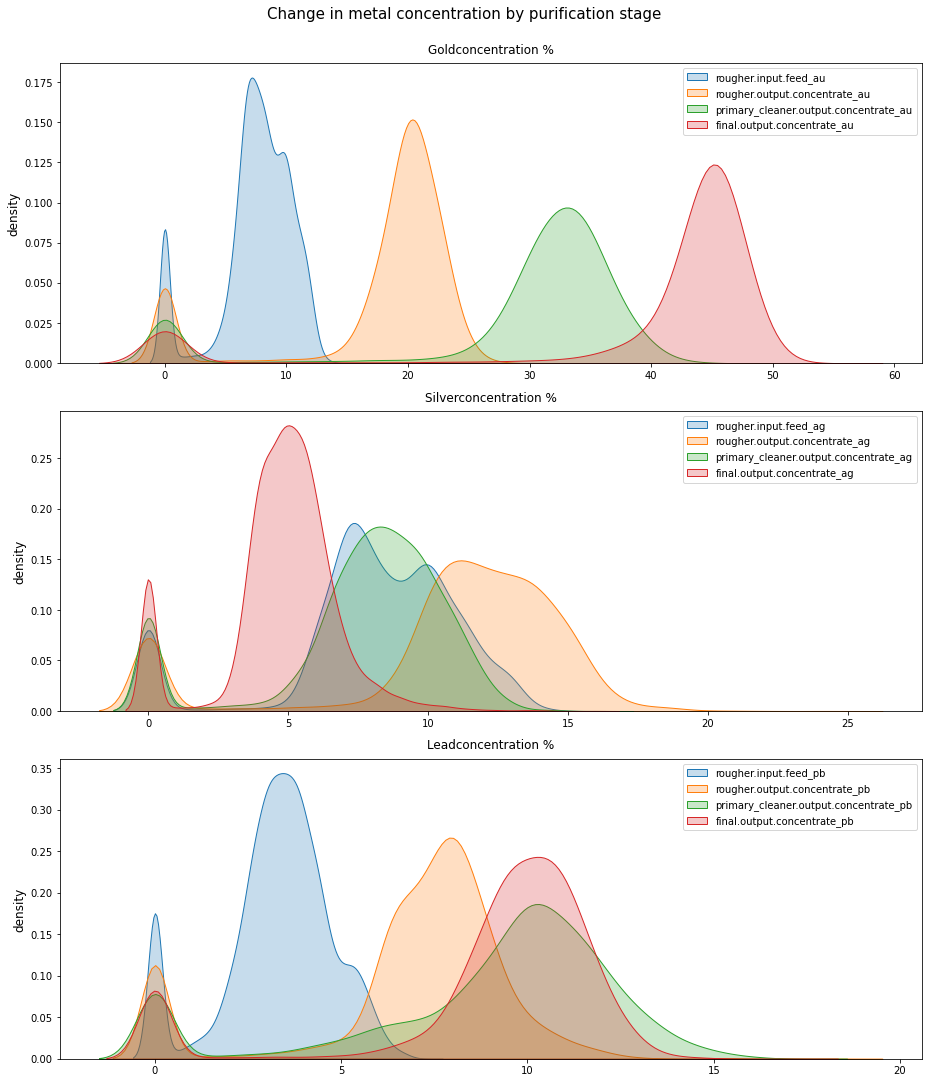

In [73]:
con=['rougher.input.feed','rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate']
metals={'_au':'Gold','_ag':'Silver','_pb':'Lead'}
#Let's create plot for each purification stage
fig, axes =plt.subplots(nrows=3,ncols=1,figsize=(13,15),sharey=False)
fig.suptitle('Change in metal concentration by purification stage',fontsize=15,y=1)

for x in metals.keys():
    for c in con:
        ax=list(metals.keys()).index(x)
        sns.kdeplot(gold_full[(c+x)],ax=axes[ax],shade='fill',label=(c+x))
        axes[ax].legend()
        axes[ax].set_xlabel(metals[x]+'concentration %',fontsize=12,labelpad=10)
        axes[ax].xaxis.set_label_position('top')
        axes[ax].set_ylabel('density',fontsize=12)
plt.tight_layout()
plt.show()

Gold recovery - with each steps of purification the concentration is increasing which is what we want to see.

Silver - from the second stage of purification the concentration is decreasing.

Lead - the concentration remains the same after 3rd step.

Also there is problematic data of zero concentration for each step it could be problem with : technology, data corruption or outliers.

2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

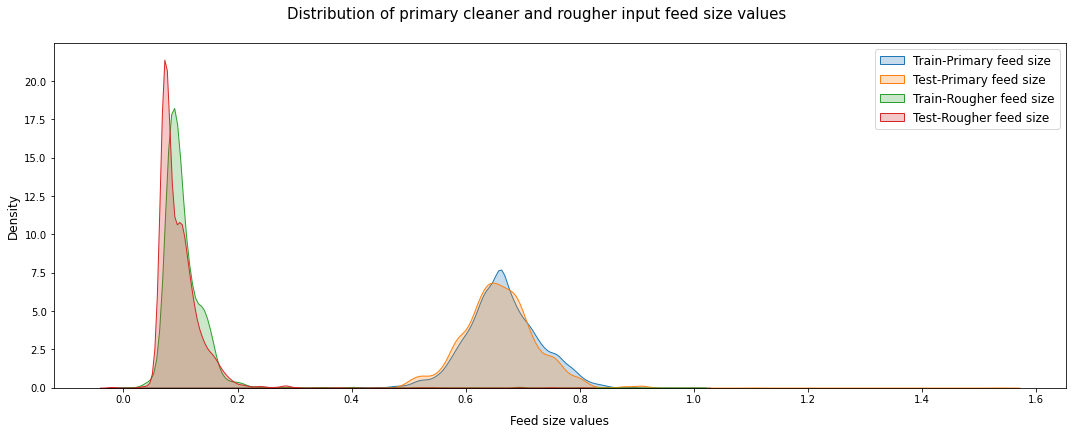

In [74]:
fig=plt.figure(figsize=(15,6))
fig.suptitle('Distribution of primary cleaner and rougher input feed size values',fontsize=15,y=1)
sns.kdeplot(gold_train_scaled['primary_cleaner.input.feed_size'],fill=True,label='Train-Primary feed size')
sns.kdeplot(gold_test_scaled['primary_cleaner.input.feed_size'],fill=True,label='Test-Primary feed size')
sns.kdeplot(gold_train_scaled['rougher.input.feed_size'],fill=True,label='Train-Rougher feed size')
sns.kdeplot(gold_test_scaled['rougher.input.feed_size'],fill=True,label='Test-Rougher feed size')
plt.legend(fontsize=12)
plt.xlabel('Feed size values',fontsize=12,labelpad=10)
plt.ylabel('Density',fontsize=12)
plt.tight_layout()
plt.show()

From the plot we see that distribution are pretty much the same.

2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

Let's create a function to get the total concentration of all metals.

In [75]:
def tot_con_metal(df,stage):
    metal_handles=list(metals.keys())
    tot_con=df[stage+metal_handles[0]]+df[stage+metal_handles[1]]+df[stage+metal_handles[2]]
    return tot_con

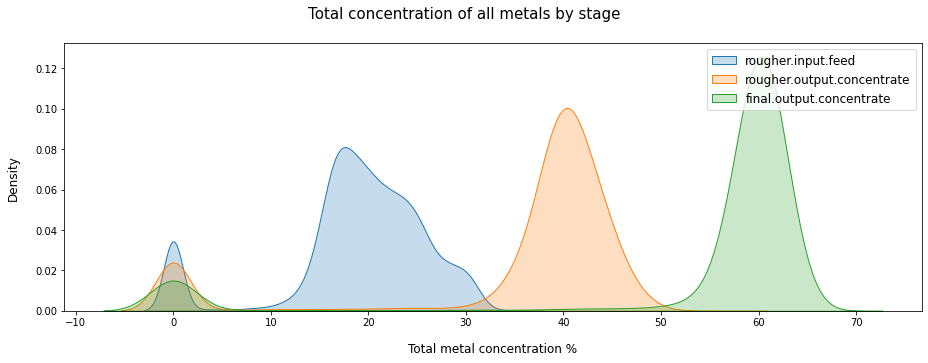

In [76]:
fig=plt.figure(figsize=(13,5))
fig.suptitle('Total concentration of all metals by stage',fontsize=15,y=1)
sns.kdeplot(tot_con_metal(gold_full,'rougher.input.feed'),label='rougher.input.feed',fill=True)
sns.kdeplot(tot_con_metal(gold_full,'rougher.output.concentrate'),label='rougher.output.concentrate',fill=True)
sns.kdeplot(tot_con_metal(gold_full,'final.output.concentrate'),label='final.output.concentrate',fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total metal concentration %',fontsize=12,labelpad=15)
plt.ylabel('Density',fontsize=12,labelpad=15)
plt.tight_layout()
plt.show()

We need to cut the data from concentration value of 10 to cut the outliers.

In [77]:
gold_full_filt=gold_full.loc[(gold_full[['rougher.input.feed_au','rougher.input.feed_pb','rougher.input.feed_ag']].sum(axis=1)>10)\
                            &(gold_full[['rougher.output.concentrate_au','rougher.output.concentrate_pb','rougher.output.concentrate_ag']].sum(axis=1)>10)\
                            &(gold_full[['final.output.concentrate_au','final.output.concentrate_pb','final.output.concentrate_ag']].sum(axis=1)>10)]

Let's see the new destribution.

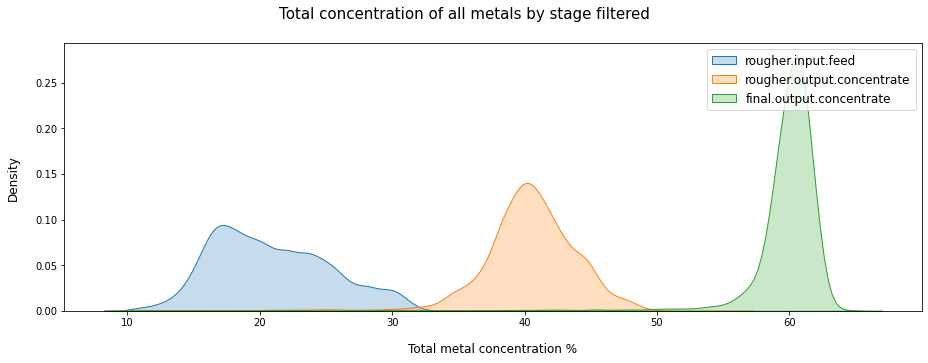

In [78]:
fig=plt.figure(figsize=(13,5))
fig.suptitle('Total concentration of all metals by stage filtered',fontsize=15,y=1)
sns.kdeplot(tot_con_metal(gold_full_filt,'rougher.input.feed'),label='rougher.input.feed',fill=True)
sns.kdeplot(tot_con_metal(gold_full_filt,'rougher.output.concentrate'),label='rougher.output.concentrate',fill=True)
sns.kdeplot(tot_con_metal(gold_full_filt,'final.output.concentrate'),label='final.output.concentrate',fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total metal concentration %',fontsize=12,labelpad=15)
plt.ylabel('Density',fontsize=12,labelpad=15)
plt.tight_layout()
plt.show()

No outliers anymore.

In [79]:
gold_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   rougher.output.recovery                     14149 non-null  float64
 2   final.output.recovery                       14149 non-null  float64
 3   primary_cleaner.input.sulfate               14149 non-null  float64
 4   primary_cleaner.input.depressant            14149 non-null  float64
 5   primary_cleaner.input.feed_size             14149 non-null  float64
 6   primary_cleaner.input.xanthate              14149 non-null  float64
 7   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64
 8   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64
 9   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64
 10  primary_cl

In [80]:
tot_old=[len(gold_train_scaled),len(gold_test_scaled)]

#removing outliers from test and train dataframe
gold_train_scaled=gold_train_scaled.loc[gold_train_scaled['date'].isin(gold_full_filt['date'])].reset_index(drop=True)
gold_test_scaled=gold_test_scaled.loc[gold_test_scaled['date'].isin(gold_full_filt['date'])].reset_index(drop=True)

display(pd.DataFrame([[tot_old[0],len(gold_train_scaled),round((100-(len(gold_train_scaled)/tot_old[0])*100),2)],[tot_old[1],len(gold_test_scaled),round((100-(len(gold_test_scaled)/tot_old[1])*100),2)]],columns=['Initial Len','New Len','Diff %'],index=['gold train','gold test']))

,Initial Len,New Len,Diff %
gold train,14149,13650,3.53
gold test,5290,5133,2.97


The loss is only 3.53 % not bad.

##  Build the model.

3.1. Write a function to calculate the final sMAPE value.

In [81]:
# function fot sMAPE
def smape2(y_true,y_pred):
    smape=np.mean(abs(y_pred-y_true)/((abs(y_true)+abs(y_pred))/2))*100
    return smape
# function for colculation of sMAPE
def f_smape(y_true,y_pred):
    predicted_rough,predicted_final=y_pred[:,0],y_pred[:,1]
    true_rough,true_final=y_true[:,0],y_true[:,1]
    f_smape=(0.25*(smape2(true_rough,predicted_rough)))+(0.75*(smape2(true_final,predicted_final)))
    return f_smape
    

Let's create targets and faetures to to train and test dataframes.

In [82]:
targets=['rougher.output.recovery','final.output.recovery']
features=[x for x in gold_train_scaled if x not in targets and x !='date']

#splitting training and testing data to features and targets
target_train,target_test=gold_train_scaled[targets].values,gold_test_scaled[targets].values
features_train,features_test=gold_train_scaled[features].values,gold_test_scaled[features].values

3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [87]:
#scorer for gridsearch CV
smape=make_scorer(f_smape,greater_is_better=False)

#function to train amd fit models using gridserach CV
def train_fit_score(model,params,name):
    model=GridSearchCV(model, param_grid=params,cv=5,scoring=smape,verbose=0,refit=True)
    model.fit(features_train,target_train)
    return pd.DataFrame([[name,abs(model.best_score_),model.best_params_]],columns=['estimator','best score','best params'])    

In [90]:
DecisionTree=train_fit_score(DecisionTreeRegressor(random_state=12345),\
                             {'max_depth':range(5,10,5),\
                              'min_impurity_decrease':np.arange(0.01,0.20,0.02),\
                              'min_samples_split':range(1,10,2)},'Decision Tree')

In [91]:
LinearRegressor=train_fit_score(LinearRegression(),{},'Linear Regressor')

In [92]:
LassoRegressor=train_fit_score(Lasso(random_state=12345),\
                              {'alpha':np.arange(0.01,1,0.05)},'Lasso Regressor')

In [93]:
KNNeighbors=train_fit_score(KNeighborsRegressor(),\
                           {'n_neighbors':range(2,10,1),\
                           'weights':['uniform','distance']},'KNeighbors REgressor')

In [94]:
RandomForest=train_fit_score(RandomForestRegressor(random_state=12345),\
                            {'n_estimators':range(10,85,25),\
                            'max_depth':range(5,45,10),\
                            'min_impurity_decrease':np.arange(0.05,0.25,0.1)},'Random Forest')

In [95]:
#the best score from all regressors
scores=pd.concat([DecisionTree,LinearRegressor,LassoRegressor,KNNeighbors,RandomForest]).set_index('estimator')
scores["best score"]=scores['best score'].round(2)
display(scores.drop('best params',axis=1))

,best score
estimator,
Decision Tree,9.18
Linear Regressor,10.01
Lasso Regressor,8.51
KNeighbors REgressor,9.74
Random Forest,8.96


From the results above the Lasso Regressor has the lowest sMAPE score therefore this model is the best to perfom test on it.

Let's test the model.

In [102]:
lasso_model=Lasso(**scores['best params'][2]).fit(features_train,target_train)

lasso_smape=round(f_smape(target_test,lasso_model.predict(features_test)),2)
print('The result of sMAPE score done by Lasso Regressor on test dataframe is:',lasso_smape )

The result of sMAPE score done by Lasso Regressor on test dataframe is: 6.28


The result is even better than in training. However, we need to perform sanity check. 

In [103]:
sanity_check=f_smape(target_test,np.tile(np.mean(target_train,axis=0),(len(target_test),1)))
print('smape for sanity check is:',sanity_check)

smape for sanity check is: 7.538551031809307


The smape of sanity check a bit higher however this difference is insignificant, therefore we can conclude that Lasso Regressor works fine.

Conclusion.

The main idea of this project was to find the best prediction model for gold recovery, and the best model is Lasso Regressor.

From data we got I would ask to provide cleaner data next time to see if results for finding best model for recovery predictions will change.

All the best!